In [1]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.optim.lr_scheduler as lr_scheduler

# Dependencies for data extraction
import netCDF4 as NC
import glob
from matplotlib import pyplot as plt
import os
import pandas as pd

from torchvision import transforms

In [2]:
path = "C:/Users/ASUS/OneDrive - Indian Institute of Technology Bombay/Machine Learning/ML projects/SLP/data"
temporary = os.listdir(path)
data_files = glob.glob(path+os.sep+'hyd_temp_*.nc')

A=[]
U=[]

time = np.empty([0])
Temperature_values_loc = np.empty([0])
a_smallest = 321768
u_smallest = 321768

for i in range(len(data_files)):
    Data_filename = NC.Dataset(data_files[i],'r')
    time = np.append(time, Data_filename['time'])
    # print(Data_filename['plevel'][0])
    if i%2==0:
      #Temperature_values_loc_a = np.append(Temperature_values_loc_a, Data_filename['TMP_prl'][:,0,1,1])
      #time_a = np.append(time_a, Data_filename['time'])
      A.append(Data_filename['TMP_prl'][:,0,1,1])

      a_smallest = min(a_smallest,len(A[-1]))

    else:
      # Temperature_values_loc_u = np.append(Temperature_values_loc_u, Data_filename['TMP_prl'][:,0,1,1])
      # time_u = np.append(time_u, Data_filename['time'])
      U.append(Data_filename['TMP_prl'][:,0,1,1])

      u_smallest = min(u_smallest, len(U[-1])) 

#temp_data = list(zip(time,Temperature_values_loc))
#temp_df=pd.DataFrame(temp_data ,columns=["time","Temperature"])

# for month:-
a_month=[]
u_month=[]

# A=np.array(A)
# U=np.array(U)

temp1=A[:][:2880]
temp2=U[:][:2880]

a_num=0
u_num=0

for i in range(16):
  if i%2==0:
    for j in range(12):
      if j%2==0:
        a_month.append(temp1[a_num][240*j:240*(j+1)])
            
      else:
        u_month.append(temp1[a_num][240*j:240*(j+1)])
      
    a_num=a_num + 1

  else:
    for j in range(12):
      if j%2==0:
        a_month.append(temp2[u_num][240*j:240*(j+1)])
    
      else:
        u_month.append(temp2[u_num][240*j:240*(j+1)])

    u_num=u_num+1

a_month=np.array(a_month)
u_month=np.array(u_month)

In [3]:
# Preparing Dataframe
temp=[]

for i in range(8):
    temp.append(A[i])
    temp.append(U[i])

temp=[item for sublist in temp for item in sublist]
temp=np.array(temp)

Time=np.array([item for item in time])

df = pd.DataFrame({'Temp(K)': temp, 'Time': Time})

In [4]:
# Making time as the index 
df.index = df['Time']
df

,Temp(K),Time
Time,,
6.311520e+08,294.323303,6.311520e+08
6.311628e+08,293.756348,6.311628e+08
6.311736e+08,295.595245,6.311736e+08
6.311844e+08,299.542053,6.311844e+08
6.311952e+08,301.178284,6.311952e+08
...,...,...
1.136020e+09,300.306488,1.136020e+09
1.136030e+09,299.925568,1.136030e+09
1.136041e+09,297.592316,1.136041e+09


In [5]:
# Creating the x and y labels :- the example is given below
# [[[1], [2], [3], [4], [5]]] [6]
# [[[2], [3], [4], [5], [6]]] [7]
# [[[3], [4], [5], [6], [7]]] [8]

def df_to_X_y(df, window_size=5):
  df_as_np = df.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = [[a] for a in df_as_np[i:i+window_size]]
    X.append(row)
    label = df_as_np[i+window_size]
    y.append(label)
  return np.array(X), np.array(y)

In [6]:
# Normalizing temperature values

temp_mean = np.mean(df['Temp(K)'])
temp_std = np.std(df['Temp(K)'])

df['Temp(K)'] = (df['Temp(K)'] - temp_mean)/temp_std

temper = df['Temp(K)']

In [7]:
WINDOW_SIZE = 5
X1, y1 = df_to_X_y(temper, WINDOW_SIZE)
X1.shape, y1.shape

((46747, 5, 1), (46747,))

In [8]:
# Split into train, validation and test sets

X_train1, y_train1 = X1[:40000], y1[:40000]
#X_val1, y_val1 = X1[30000:40000], y1[30000:40000]
X_test1, y_test1 = X1[40000:], y1[40000:]
X_train1.shape, y_train1.shape, X_test1.shape, y_test1.shape

((40000, 5, 1), (40000,), (6747, 5, 1), (6747,))

In [9]:
# X_train1 = np.reshape(X_train1,(-1,len(X_train1)))
# X_test1 = np.reshape(X_test1,(-1,len(X_test1)))
X_train = torch.tensor(X_train1).reshape([-1,1,5])
X_test = torch.tensor(X_test1).reshape([-1,1,5])
y_train = torch.tensor(y_train1).reshape([-1,1,1])
y_test = torch.tensor(y_test1).reshape([-1,1,1])
y_train[1].size()

torch.Size([1, 1])

In [10]:
class Model1(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=5, hidden_size=50, num_layers=1, batch_first=True)
        #self.bn0 = nn.BatchNorm1d(1)
        self.linear = nn.Linear(50, 1)

    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x)
        return x
 
model = Model1()
optimizer = torch.optim.Adam(model.parameters())
loss_fn = nn.MSELoss()
train_loader = data.DataLoader((X_train, y_train), shuffle=False, batch_size=1)
test_loader = data.DataLoader((X_test, y_test), shuffle=False, batch_size=1)

In [11]:
n_epochs = 20
batch_size = 32
for epoch in range(n_epochs):
    model.train()
    """
    # For batch training
    for i in range(int(len(X_train)/batch_size)):
        y_pred = model(X_train[batch_size*i : min(batch_size*(i+1),len(X_train))])
        loss = loss_fn(y_pred, y_train[batch_size*i : min(batch_size*(i+1),len(X_train))])
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    """

    # For autoregressive type training 
    next_batch = X_train[0]
    predicted = []
    for i in range(int(len(X_train))):
        y_pred = model(next_batch)
        predicted.append(y_pred.item())
        next_batch = X_train[min(i+1, len(X_train)-1)].clone()
        temp = torch.Tensor(predicted)
        if(len(predicted)<5):
            next_batch[0,5-len(predicted):5] = temp

        else:
            next_batch[0,:] = temp[(len(predicted) - 5):]
            
        loss = loss_fn(y_pred, y_train[i])
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()  
    
    # Validation
    if epoch % 5 != 0:
        continue
    model.eval()
    with torch.no_grad():
        y_pred = model(X_train)
        train_rmse = np.sqrt(loss_fn(y_pred, y_train))
        y_pred = model(X_test)
        test_rmse = np.sqrt(loss_fn(y_pred, y_test))
    print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse, test_rmse))

TypeError: can't assign a list to a torch.FloatTensor

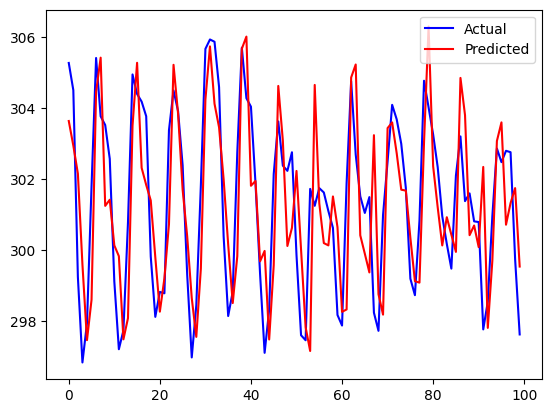

In [ ]:
with torch.no_grad():
    # shift train predictions for plotting
    y_pred = model(X_test).flatten()
    actuals =y_test.flatten()
    
    y_pred = (y_pred*temp_std) + temp_mean
    actuals = (actuals*temp_std) + temp_mean
# plot
plt.plot(actuals[:100], c='b', label = 'Actual')
plt.plot(y_pred[:100], c='r', label = 'Predicted')
plt.legend()
plt.show()